In [4]:
#imports, data folders and necessary requirements
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sn
import ast

import os
import json
from sklearn import preprocessing

!pip install --user -U nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from nltk.sentiment import SentimentAnalyzer
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment.util import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

!pip install -U textblob
from textblob import TextBlob

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.add(string.punctuation)

PATH_FOLDER = "MovieSummaries/"


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# The first section: process summary_metadata
### Credit goes to to Aziz for his codes
### Codes come from Sentiment Analysis (summary_plot dataset)

In [ ]:
#extract dataset and create a copy for later use
summary_file_name = os.path.join(PATH_FOLDER, 'plot_summaries.txt')
summary_metadata_original = pd.read_csv(summary_file_name,  sep="\t")
summary_metadata_original.columns =["Movie ID", "Movie Summary"]

summary_metadata_original["Movie Summary"] = summary_metadata_original["Movie Summary"].astype("string")

summary_metadata = summary_metadata_original.copy()
summary_metadata_original.shape

In [ ]:
#Extract each column in a new Series variables
Movie_IDs = summary_metadata["Movie ID"].squeeze()
Movie_Summaries = summary_metadata["Movie Summary"].squeeze()

#Check uniqueness of values in each Series variable
print(Movie_IDs.duplicated().sum()) # contains 0 duplicate values
print(Movie_Summaries.duplicated().sum()) # contains 8 duplicate values

#Remove duplicate values
summary_metadata = summary_metadata.drop_duplicates("Movie Summary")
print(summary_metadata.shape)

In [ ]:
#function used to tokenize into dataframe columns into single words
def tokenize(column):
    """Tokenizes a Pandas dataframe column and returns a list of tokens.

    Args:
        column: Pandas dataframe column.

    Returns:
        tokens (list): Tokenized list.
    """

    tokens = nltk.word_tokenize(column)
    return [w for w in tokens if w.isalpha()] 

In [ ]:
#add a column containing tokenized summaries
summary_metadata['tokenized_summary'] = summary_metadata.apply(lambda x: tokenize(x['Movie Summary']), axis=1)

summary_metadata

In [ ]:
#filter the column containing tokenized text by deleting all stopwords
summary_metadata['filtered_Tokens'] = summary_metadata['tokenized_summary'].apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words])

summary_metadata

In [ ]:
# Export the summary metadata for temporary use.
summary_metadata.to_csv("summary_metadata_topic_model.csv",index=False)

# The second section: Topic Modeling

We apply Latent Dirichlet Allocation (LDA) for topic modeling on a set of movie summaries. It has revealed five distinct themes, each characterized by the top ten most significant words. The interpretation of these themes provides insights into the types of narratives and genres represented in the dataset:

* Adventure Narratives (Topic 0): The key words such as "tells," "car," "town," "finds," and "group" can represent a group embarks on a journey about adventure and discovery, such as treasure hunts around a town.

* Family Drama (Topic 1): The highlighted words like "father," "mother," "family," and "son" can indicate stories about relationships and life of family members, including parental roles, family bonds, and teenage growth.

* Children Animation (Topic 2): The mention of character names such as "Tom" and "Jerry," combined with words like "school" and "bugs," may suggest animated features targeted at children audience. These movies are likely to have comedic actions with animated characters that entertain children.

* War Documentaries (Topic 3): The words such as "war," "killed," "king," and "army," imply historical or military-focused content. The movies in this category may show documentaries of historical events and causes and impacts of warfare.

* Crime Thrillers (Topic 4): This theme could lie in crime and conflicts, as suggested by words like "police," "jack," "john," and "wife." It may involve police investigations and law enforcement with suspenseful and emotional plots.

In [16]:
# Load the summary metadata file
file_path = 'summary_metadata_topic_model.csv'
summary_metadata_sample = pd.read_csv(file_path)

# Preview
summary_metadata_sample.head()

,Movie ID,Movie Summary,tokenized_summary,filtered_Tokens
0,31186339,The nation of Panem consists of a wealthy Capi...,"['The', 'nation', 'of', 'Panem', 'consists', '...","['nation', 'Panem', 'consists', 'wealthy', 'Ca..."
1,20663735,Poovalli Induchoodan is sentenced for six yea...,"['Poovalli', 'Induchoodan', 'is', 'sentenced',...","['Poovalli', 'Induchoodan', 'sentenced', 'six'..."
2,2231378,"The Lemon Drop Kid , a New York City swindler,...","['The', 'Lemon', 'Drop', 'Kid', 'a', 'New', 'Y...","['Lemon', 'Drop', 'Kid', 'New', 'York', 'City'..."
3,595909,Seventh-day Adventist Church pastor Michael Ch...,"['Adventist', 'Church', 'pastor', 'Michael', '...","['Adventist', 'Church', 'pastor', 'Michael', '..."
4,5272176,The president is on his way to give a speech. ...,"['The', 'president', 'is', 'on', 'his', 'way',...","['president', 'way', 'give', 'speech', 'travel..."


In [17]:
#### Use Latent Dirichlet Allocation (LDA) to identify topics ####

# Convert string representations of lists back into lists
summary_metadata_sample['filtered_Tokens'] = summary_metadata_sample['filtered_Tokens'].apply(ast.literal_eval)

# Join the tokens back into strings for vectorization
summary_metadata_sample['processed_summary'] = summary_metadata_sample['filtered_Tokens'].apply(lambda x: ' '.join(x))

# Vectorization
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(summary_metadata_sample['processed_summary'])

# LDA Model
lda = LatentDirichletAllocation(n_components=5, max_iter=5, random_state=0)
lda.fit(dtm)

# Function to display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Set top 10 words from each topic will be shown
no_top_words = 10

# Check which method is available in the CountVectorizer instance
if hasattr(vectorizer, 'get_feature_names_out'):
    feature_names = vectorizer.get_feature_names_out()
else:
    feature_names = vectorizer.get_feature_names()

# Display topics    
display_topics(lda, feature_names, no_top_words)

Topic 0:
film man town tells car new later finds time group
Topic 1:
father love mother family life tells home house man son
Topic 2:
tom jerry sam house tells gets tries school bugs goes
Topic 3:
film war world new men time killed king army later
Topic 4:
police jack film john family man life father new wife


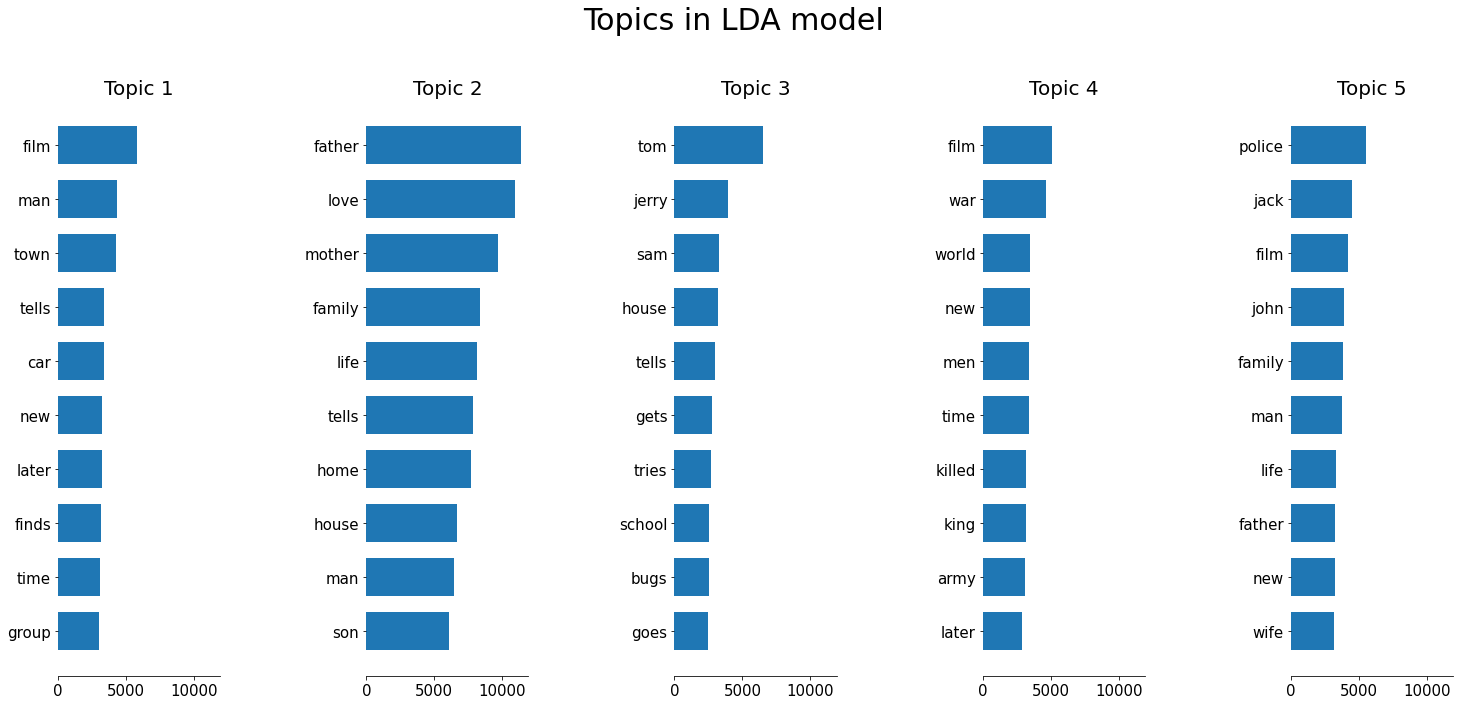

In [22]:
#### Visualize the results ####

# Function to plot top words for each topic

def plot_top_words_final(model, feature_names, n_top_words, title):
    n_topics = model.components_.shape[0]
    fig, axes = plt.subplots(1, n_topics, figsize=(5 * n_topics, 10), sharex=True)

    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx + 1}', fontdict={'fontsize': 20})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=15)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)

    plt.subplots_adjust(top=0.85, bottom=0.05, wspace=0.90, hspace=0.3)
    fig.suptitle(title, fontsize=30)
    plt.show()

# Check which method is available in the CountVectorizer instance
if hasattr(vectorizer, 'get_feature_names_out'):
    feature_names = vectorizer.get_feature_names_out()
else:
    feature_names = vectorizer.get_feature_names()

# Redefine n_top_words
n_top_words = 10

# Plot the top words for each topic
plot_top_words_final(lda, feature_names, n_top_words, 'Topics in LDA model')
